# Gaussian Mixture Model via Gradient Descent

In this first lab exercise, we will see how we can train a Gaussian Mixture Model (GMM) via gradient descent:

- first, we will consider independant bivariate Gaussians, i.e. the correlation coefficients in the correlation matrix are null, therefore we can simply store the diagonal and model each coordinate independently - this part is already done, you just need to study the code to understand it
- second, we will consider bivariate Gaussian with (possibly) non null correlation coefficients

Your goal is to study this code, play with params and understand what is going on!

In [1]:
# import a lot of useful stuff

import numpy as np
import math
import sklearn.metrics
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import HTML
import scipy.stats
from sklearn.datasets import make_circles

import torch
import torch.nn as nn
import torch.optim
import math
%matplotlib inline

## 1. Simple preliminary example

In this section, we illustrate how we use Pytorch for optimizing the parameters of a probability distribution.

In [2]:
# A Pytorch module is an object that contains parameters that we are going to learn,
# in this case the parameters of an univariate Gaussian.
# It also defines a forward pass function.
class UnivariateGaussian(nn.Module):
    def __init__(self):
        super().__init__()
        
        # an univariate Gaussian is defined by a mean and a standard deviation
        self.mean = nn.Parameter(torch.zeros(1))
        # the standard deviation (std) of a Gaussian must be strictily positive.
        # Instead, we will learn the log of the std which is unconstrained.
        # then, log_std.exp() is equal to the std
        self.log_std = nn.Parameter(torch.zeros(1))
        
    # the forward function return the log of the PDF
    def forward(self, x):
        return \
            - math.log(math.sqrt(2 * math.pi)) \
            - self.log_std \
            - 0.5 * ((x - self.mean) ** 2) / (self.log_std.exp() ** 2)

In [3]:
# We generate training data from a Gaussian with mean 5 and std 2
gold_data = torch.FloatTensor([np.random.normal(loc=5, scale=2) for _ in range(1000)])

# we can estimate the mean and std from the data using the closed form formula

print("Closed form solution:")
print(" - mean =", gold_data.mean())
print(" - std =", gold_data.std(unbiased=False))

Closed form solution:
 - mean = tensor(5.0400)
 - std = tensor(2.0095)


In [5]:
# create an univariate Gaussian
unig = UnivariateGaussian()

# optimizer
optimizer = torch.optim.SGD(unig.parameters(), lr=0.01, momentum=0.9)
# We could have also used Adam
#optimizer = torch.optim.Adam(unig.parameters(), lr=0.1)

# Training loop,
# We do 1000 gradient updates here
for _ in range(1000):
    # we first need to set the gradient to 0
    # the reason is that each call to the .backward function *accumulate* gradient
    optimizer.zero_grad()
    
    # compute the log PDF each each data sample,
    # log_pdf is a vector of the size of the dataset
    log_pdf = unig(gold_data)
    #print(log_pdf.shape)
    # we sum all PDF and then normalize
    # it is usual to normalize by the number of sample
    # so that the objective don't explode.
    # i.e. the parameter estimation problem is:
    # min_theta -\sum_x (1/|D|) * log p(x)
    loss = -torch.sum(log_pdf) / len(gold_data)

    loss.backward() # compute the gradient
    optimizer.step() # update the parameters
    
print("Learned model:")
print(" - mean =", unig.mean.item())
print(" - std =", unig.log_std.exp().item())

Learned model:
 - mean = 5.040016174316406
 - std = 2.0094797611236572


In the following we solve the same problem but using stochastic gradient descent, i.e. at each update we use only a batch of data.

In [6]:
unig = UnivariateGaussian()
optimizer = torch.optim.SGD(unig.parameters(), lr=0.01, momentum=0.9)

# Here, 100 is not the number of updates
# but the number of time we will loop over the data
for _ in range(100):
    # we permute the dataset so at each
    # iteration we will look at the data
    # in a different order
    gold_data[:] = gold_data[torch.randperm(len(gold_data))]
    
    # batch of size 10
    for i in range(0, len(gold_data), 10):
        batch = gold_data[i : i+10]
        optimizer.zero_grad()

        log_pdf = unig(batch)
        # here we norm by the size of the batch
        loss = -torch.sum(log_pdf) / len(batch)

        loss.backward() # compute the gradient
        optimizer.step() # update the parameters
    
print("Learned model:")
print(" - mean =", unig.mean.item())
print(" - std =", unig.log_std.exp().item())

Learned model:
 - mean = 5.0556559562683105
 - std = 2.080714464187622


## 2. Data

We now generate the data we will use. They come from 3 different bivariate Gaussians where only one of them has a non null correlation.

In [7]:
n_coordinates = 2

n_gold_clusters = 3
n_gold_samples = 1000

# The prior distribution on clusters is not uniform!
gold_cluster_prior = [0.2, 0.4, 0.4]

gold_x_means = np.array(np.array([ [-1, -1], [-1, 1], [1, 1] ]))
gold_x_cov = np.array([
    [
        [0.5**2, 0],
        [0, 0.2**2],
    ],
    [
        [0.3**2, 0],
        [0, 0.3**2],
    ],
    [
        [0.4**2, 0.8 * 0.4 * 0.5],
        [0.8 * 0.4 * 0.5, 0.5**2],
    ],
])

# sampling

# first we sample the cluster for each point
gold_clusters = np.random.choice(n_gold_clusters, n_gold_samples, p=gold_cluster_prior)

# then we sample the coordinates
gold_data = np.empty((n_gold_samples, n_coordinates))
for i in range(n_gold_samples):
    gold_data[i] = np.random.multivariate_normal(gold_x_means[gold_clusters[i]], gold_x_cov[gold_clusters[i]])

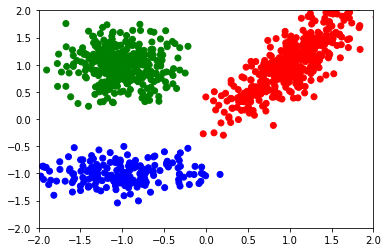

In [69]:
colors = np.array(["blue", "green", "red"])

fig, ax = plt.subplots()
ax.set_xlim((-2, 2))
ax.set_ylim((-2, 2))

ax.scatter(gold_data[:,0], gold_data[:,1], color=colors[gold_clusters])

In [70]:
gold_data[0]

array([1.28219615, 0.88145059])

## 1.3. Independent bivariate Gaussians

**IMPORTANT** You need to exactly understand what is going on in the forward function!

In [71]:
class GaussianMixture(nn.Module):
    def __init__(self, n_clusters, n_coordinates):
        super().__init__()
        
        # Parameters of the prior distribution
        # we will use an exponential parameterization of the categorical distribution
        # so no constraint on this :)
        self.prior = nn.Parameter(torch.zeros(n_clusters))
        
        
        self.mean = nn.Parameter(torch.empty((1, n_clusters, n_coordinates)).normal_())
        self.log_std = nn.Parameter(torch.empty((1, n_clusters, n_coordinates)).normal_())
        
    # return log of the pdf (i.e. marginalize over the latent variable)
    def forward(self, x):
        # shape x: (n_sample, 1, n_output)
        x = x.unsqueeze(1)
        # shape: (n_sample, n_latent, n_output)
        print('x= ',x[0])
        pdf = \
            - math.log(math.sqrt(2 * math.pi)) \
            - self.log_std \
            - 0.5 * ((x - self.mean) ** 2) / (self.log_std.exp() ** 2)
        
        # reduce last dim
        pdf = pdf.sum(dim=2)
        pdf = pdf + self.prior.log_softmax(0).unsqueeze(0)
        pdf = pdf.logsumexp(dim=1)
        
        # shape of the return tensor is (n_sample,)
        return pdf

In [72]:
# just a function to visualize the result!
# not that there are only seven colors, so you can go only up to 7 clusters...
def visualize_independent_mixture(g):
    # sample from the learned distribution
    pred_prior = np.random.choice(g.prior.shape[0], 1000, p=g.prior.softmax(0).detach().numpy())
    pred = np.random.normal(
        loc=g.mean[0, pred_prior].detach().numpy(),
        scale=g.log_std[0, pred_prior].exp().detach().numpy()
    )

    colors = np.array([c for c in "bgrcmyk"])
    # you can do this if you want to visualize with more clusters,
    # but several clusters will have the same color...
    #colors = np.array([c for c in "bgrcmykbgrcmykbgrcmykbgrcmyk"])

    fig, ax = plt.subplots()

    ax.set_xlim((-2, 2))
    ax.set_ylim((-2, 2))

    ax.scatter(pred[:,0], pred[:,1], color=colors[pred_prior])

x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[ -0.9973,  -2.1213],
        [ -1.4985,  -5.7927],
        [-21.5127,  -1.7152]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -3.1186,  -7.2913, -23.2279], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([0., 0., 0.], requires_grad=True)
log_solfmax=  tensor([-1.0986, -1.0986, -1.0986], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.0986, -1.0986, -1.0986]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-4.2019, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.0831,  -2.0206],
        [ -1.4907,  -4.6099],
        [-21.7127,  -1.6693]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -1.9375,  -6.1007, -23.3821], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.0076, 

pdf=  tensor([[ -0.0574,  -0.0325],
        [ -1.3416,  -1.7647],
        [-17.1682,  -1.2378]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.0899,  -3.1064, -18.4061], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([ 0.6479, -1.3931,  0.7452], requires_grad=True)
log_solfmax=  tensor([-0.8029, -2.8439, -0.7057], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-0.8029, -2.8439, -0.7057]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-0.8865, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.0202,  -0.1291],
        [ -1.3397,  -1.7286],
        [-16.9760,  -1.2022]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.1088,  -3.0683, -18.1782], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([ 0.6164, -1.4214,  0.8050], requires_grad=True

pdf=  tensor(-1.2445, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[ -0.1188,  -0.1852],
        [ -1.3664,  -1.0111],
        [-19.3186,  -1.0248]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.3040,  -2.3776, -20.3434], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([ 0.6369, -1.6848,  1.0479], requires_grad=True)
log_solfmax=  tensor([-0.9579, -3.2797, -0.5470], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-0.9579, -3.2797, -0.5470]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.2496, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[ -0.1299,  -0.1783],
        [ -1.3699,  -1.0049],
        [-19.3716,  -1.0205]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.3082,  -2.3749, -20.3921], dtype=torch.float64,
       grad_fn=<Se

prior=  Parameter containing:
tensor([ 0.5937, -1.5525,  0.9588], requires_grad=True)
log_solfmax=  tensor([-0.9390, -3.0852, -0.5740], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-0.9390, -3.0852, -0.5740]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.2387, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[ -0.1002,  -0.2097],
        [ -1.8006,  -0.9623],
        [-20.0285,  -1.0352]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.3099,  -2.7629, -21.0637], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([ 0.5923, -1.5476,  0.9553], requires_grad=True)
log_solfmax=  tensor([-0.9382, -3.0780, -0.5752], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-0.9382, -3.0780, -0.5752]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.2380, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.

x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[-1.1733e-02, -2.1220e-01],
        [-3.3434e+00, -1.2959e+00],
        [-2.0986e+01, -1.0240e+00]], dtype=torch.float64,
       grad_fn=<SelectBackward>)
pdf=  tensor([ -0.2239,  -4.6393, -22.0096], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([ 0.4655, -1.3342,  0.8687], requires_grad=True)
log_solfmax=  tensor([-0.9791, -2.7787, -0.5759], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-0.9791, -2.7787, -0.5759]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.2010, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[-7.7312e-03, -2.1282e-01],
        [-3.3556e+00, -1.2976e+00],
        [-2.0915e+01, -1.0243e+00]], dtype=torch.float64,
       grad_fn=<SelectBackward>)
pdf=  tensor([ -0.2206,  -4.6533, -21.9397], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torc

unsqueeze=  tensor([[-1.1907, -2.2279, -0.5306]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.2919, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.2371,  -0.3388],
        [ -5.1135,  -0.8571],
        [-17.3028,  -1.0430]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.1016,  -5.9707, -18.3458], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([ 0.1149, -0.8933,  0.7785], requires_grad=True)
log_solfmax=  tensor([-1.1959, -2.2041, -0.5323], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.1959, -2.2041, -0.5323]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.2965, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.2348,  -0.3355],
        [ -5.1248,  -0.8800],
        [-17.3297,  -1.0432]], dtype=torch.float64, grad_fn=<Se

pdf=  tensor([ -0.2090,  -2.5506, -18.5112], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.0894, -0.6257,  0.7151], requires_grad=True)
log_solfmax=  tensor([-1.3404, -1.8767, -0.5359], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.3404, -1.8767, -0.5359]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.4946, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3045,  -0.5184],
        [ -2.3655,  -0.1396],
        [-17.4355,  -1.0436]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.2138,  -2.5051, -18.4790], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.0985, -0.6138,  0.7123], requires_grad=True)
log_solfmax=  tensor([-1.3473, -1.8626, -0.5365], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.3473, -1.8626, -0.5365]], grad_fn=<Uns

pdf=  tensor([[  0.3507,  -0.8393],
        [ -1.5986,   0.0633],
        [-17.0815,  -1.0433]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.4886,  -1.5353, -18.1248], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.3599, -0.3246,  0.6845], requires_grad=True)
log_solfmax=  tensor([-1.5846, -1.5493, -0.5403], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.5846, -1.5493, -0.5403]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.7630, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3511,  -0.8483],
        [ -1.5844,   0.0659],
        [-17.0820,  -1.0433]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.4972,  -1.5185, -18.1253], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.3663, -0.3182,  0.6845], requires_grad=True

pdf=  tensor([[  0.3562,  -1.0381],
        [ -1.3518,   0.1077],
        [-16.9568,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.6819,  -1.2440, -17.9998], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.4869, -0.2048,  0.6917], requires_grad=True)
log_solfmax=  tensor([-1.7185, -1.4363, -0.5398], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.7185, -1.4363, -0.5398]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.8374, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0397],
        [ -1.3500,   0.1080],
        [-16.9566,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.6835,  -1.2420, -17.9996], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.4879, -0.2038,  0.6918], requires_grad=True

pdf=  tensor([[  0.3562,  -1.0591],
        [ -1.3294,   0.1111],
        [-16.9453,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7030,  -1.2182, -17.9884], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.4997, -0.1932,  0.6929], requires_grad=True)
log_solfmax=  tensor([-1.7325, -1.4259, -0.5398], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.7325, -1.4259, -0.5398]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.8412, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0591],
        [ -1.3293,   0.1111],
        [-16.9454,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7030,  -1.2182, -17.9884], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.4997, -0.1932,  0.6929], requires_grad=True

prior=  Parameter containing:
tensor([-0.4990, -0.1938,  0.6928], requires_grad=True)
log_solfmax=  tensor([-1.7317, -1.4265, -0.5398], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.7317, -1.4265, -0.5398]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0578],
        [ -1.3307,   0.1110],
        [-16.9457,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7016,  -1.2197, -17.9888], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.4990, -0.1938,  0.6928], requires_grad=True)
log_solfmax=  tensor([-1.7317, -1.4265, -0.5398], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.7317, -1.4265, -0.5398]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.

x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0574],
        [ -1.3311,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7012,  -1.2202, -17.9889], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.4988, -0.1941,  0.6928], requires_grad=True)
log_solfmax=  tensor([-1.7314, -1.4267, -0.5398], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.7314, -1.4267, -0.5398]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0574],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7012,  -1.2202, -17.9889], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
te

pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7011,  -1.2203, -17.9890], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.4987, -0.1941,  0.6928], requires_grad=True)
log_solfmax=  tensor([-1.7314, -1.4267, -0.5398], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.7314, -1.4267, -0.5398]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7011,  -1.2203, -17.9890], dtype=torch.float64,
       grad_fn=<Se

log_solfmax=  tensor([-1.7314, -1.4267, -0.5398], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.7314, -1.4267, -0.5398]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7011,  -1.2203, -17.9890], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.4987, -0.1941,  0.6928], requires_grad=True)
log_solfmax=  tensor([-1.7314, -1.4267, -0.5398], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.7314, -1.4267, -0.5398]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.

torch.Size([1, 3])
pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7011,  -1.2203, -17.9890], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.4987, -0.1941,  0.6928], requires_grad=True)
log_solfmax=  tensor([-1.7314, -1.4267, -0.5398], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.7314, -1.4267, -0.5398]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7011,  -1.2203, -17.9890], dtype=torch.float64,

unsqueeze=  tensor([[-1.7314, -1.4267, -0.5398]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7011,  -1.2203, -17.9890], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.4987, -0.1941,  0.6928], requires_grad=True)
log_solfmax=  tensor([-1.7314, -1.4267, -0.5398], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.7314, -1.4267, -0.5398]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<Se

prior=  Parameter containing:
tensor([-0.4987, -0.1941,  0.6928], requires_grad=True)
log_solfmax=  tensor([-1.7314, -1.4267, -0.5398], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.7314, -1.4267, -0.5398]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7011,  -1.2203, -17.9890], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.4987, -0.1941,  0.6928], requires_grad=True)
log_solfmax=  tensor([-1.7314, -1.4267, -0.5398], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.7314, -1.4267, -0.5398]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.

prior=  Parameter containing:
tensor([-0.4987, -0.1941,  0.6928], requires_grad=True)
log_solfmax=  tensor([-1.7314, -1.4267, -0.5398], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.7314, -1.4267, -0.5398]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7011,  -1.2203, -17.9890], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.4987, -0.1941,  0.6928], requires_grad=True)
log_solfmax=  tensor([-1.7314, -1.4267, -0.5398], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.7314, -1.4267, -0.5398]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.

x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7011,  -1.2203, -17.9890], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.4987, -0.1941,  0.6928], requires_grad=True)
log_solfmax=  tensor([-1.7314, -1.4267, -0.5398], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.7314, -1.4267, -0.5398]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7011,  -1.2203, -17.9890], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
te

x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7011,  -1.2203, -17.9890], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.4987, -0.1941,  0.6928], requires_grad=True)
log_solfmax=  tensor([-1.7314, -1.4267, -0.5398], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.7314, -1.4267, -0.5398]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7011,  -1.2203, -17.9890], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
te

pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7011,  -1.2203, -17.9890], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.4987, -0.1941,  0.6928], requires_grad=True)
log_solfmax=  tensor([-1.7314, -1.4267, -0.5398], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.7314, -1.4267, -0.5398]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7011,  -1.2203, -17.9890], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.4987, -0.1941,  0.6928], requires_grad=True

unsqueeze=  tensor([[-1.7314, -1.4267, -0.5398]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7011,  -1.2203, -17.9890], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.4987, -0.1941,  0.6928], requires_grad=True)
log_solfmax=  tensor([-1.7314, -1.4267, -0.5398], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.7314, -1.4267, -0.5398]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<Se

pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7011,  -1.2203, -17.9890], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.4987, -0.1941,  0.6928], requires_grad=True)
log_solfmax=  tensor([-1.7314, -1.4267, -0.5398], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.7314, -1.4267, -0.5398]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7011,  -1.2203, -17.9890], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.4987, -0.1941,  0.6928], requires_grad=True

x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7011,  -1.2203, -17.9890], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.4987, -0.1941,  0.6928], requires_grad=True)
log_solfmax=  tensor([-1.7314, -1.4267, -0.5398], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.7314, -1.4267, -0.5398]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7011,  -1.2203, -17.9890], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
te

pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7011,  -1.2203, -17.9890], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.4987, -0.1941,  0.6928], requires_grad=True)
log_solfmax=  tensor([-1.7314, -1.4267, -0.5398], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.7314, -1.4267, -0.5398]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7011,  -1.2203, -17.9890], dtype=torch.float64,
       grad_fn=<Se

torch.Size([1, 3])
pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7011,  -1.2203, -17.9890], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.4987, -0.1941,  0.6928], requires_grad=True)
log_solfmax=  tensor([-1.7314, -1.4267, -0.5398], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.7314, -1.4267, -0.5398]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7011,  -1.2203, -17.9890], dtype=torch.float64,

pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7011,  -1.2203, -17.9890], dtype=torch.float64,
       grad_fn=<SelectBackward>)
torch.Size([1000, 3])
prior=  Parameter containing:
tensor([-0.4987, -0.1941,  0.6928], requires_grad=True)
log_solfmax=  tensor([-1.7314, -1.4267, -0.5398], grad_fn=<LogSoftmaxBackward>)
unsqueeze=  tensor([[-1.7314, -1.4267, -0.5398]], grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 3])
pdf=  tensor(-1.8409, dtype=torch.float64, grad_fn=<SelectBackward>)
x=  tensor([[1.2822, 0.8815]], dtype=torch.float64)
pdf=  tensor([[  0.3562,  -1.0573],
        [ -1.3312,   0.1109],
        [-16.9459,  -1.0431]], dtype=torch.float64, grad_fn=<SelectBackward>)
pdf=  tensor([ -0.7011,  -1.2203, -17.9890], dtype=torch.float64,
       grad_fn=<Se

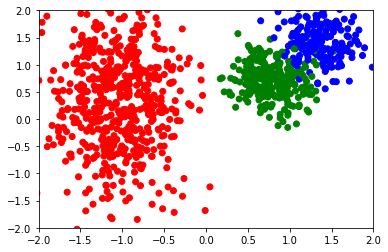

In [73]:
# Train the model with 3 latent clusters
# Note that sometimes it can completely fail (because the objective is non-convex!)
# just rerun it! :)
n_clusters = 3
g = GaussianMixture(n_clusters, n_coordinates)

optimizer = torch.optim.SGD(g.parameters(), lr=0.1, momentum=0.9)

for _ in range(1000):
    optimizer.zero_grad()
    loss = -torch.sum(g(torch.from_numpy(gold_data))) / len(gold_data)
    loss.backward()
    optimizer.step()
    
visualize_independent_mixture(g)

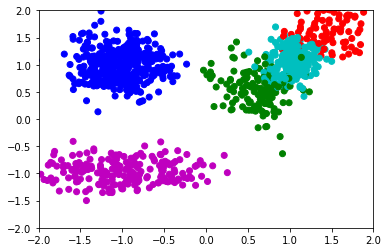

In [28]:
# On of the cluster in the dataset has a full covariance matrix,
# we cannot approximate it with a single Gaussian that has independent coordinate,
# but we can increase the number of cluster in our model to try to fit it with 
# several bivariate Gaussians!
n_clusters = 5
g = GaussianMixture(n_clusters, n_coordinates)

optimizer = torch.optim.SGD(g.parameters(), lr=0.1, momentum=0.9)

for _ in range(1000):
    optimizer.zero_grad()
    loss = -torch.sum(g(torch.from_numpy(gold_data))) / len(gold_data)
    loss.backward()
    optimizer.step()
    
visualize_independent_mixture(g)

## 1.4. GMM with full covariance bivariate Gaussian

We will now move to the same example, but using a model that can learn models with non null correlation between coordinates.

In [29]:
class GaussianMixture(nn.Module):
    # we only pass the number of clusters,
    # we have a single correlation coefficient
    # so we are restricted to 2 coordinates only
    def __init__(self, n_clusters):
        super().__init__()
        
        # Parameters of the prior distribution
        # we will use an exponential parameterization of the categorical distribution
        # so no constraint on this :)
        self.prior = nn.Parameter(torch.zeros(n_clusters))

        
        self.mean = nn.Parameter(torch.empty((1, n_clusters, 2)).normal_())
        self.log_std = nn.Parameter(torch.empty((1, n_clusters, 2)).normal_())
        
        # The correlation coefficient
        # not that we learn a reparameterization that is unconstrained,
        # and the coef is self.reparemterized_coef.tanh(),
        # so the value is between -1 and 1 as expected
        # (one limitation is that we can't have a coef=1 or =-1, but who cares?)
        self.reparameterized_coef = nn.Parameter(torch.empty((1, n_clusters)).normal_())
        
    # return log of the pdf (i.e. marginalize over the latent variable)
    # formula is avalable here: https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Bivariate_case
    # remember we are interested by the log PDF!
    def forward(self, x):
        # shape x: (n_sample, 1, n_output)
        x = x.unsqueeze(1)
        p = self.reparameterized_coef.tanh()
        # shape: (n_sample, n_latent, n_output)

        pdf = \
            - torch.log(2 * math.pi * self.log_std.exp().prod(2) * torch.sqrt(1 - p*p)) \
            - (1 / (2 * (1 - p * p))) * (
                ((x - self.mean).pow(2) / (self.log_std.exp().pow(2))).sum(2)
                - 2 * p * (x - self.mean).prod(2) / self.log_std.exp().prod(2)
            )
        
        pdf = pdf + self.prior.log_softmax(0).unsqueeze(0)
        pdf = pdf.logsumexp(dim=1)
        
        # shape of the return tensor is (n_sample,)
        return pdf

In [30]:
# On of the cluster in the dataset has a full covariance matrix,
# we cannot approximate it with a single Gaussian that has independent coordinate,
# but we can increase the number of cluster in our model to try to fit it with 
# several bivariate Gaussians!
n_clusters = 3
g = GaussianMixture(n_clusters)

optimizer = torch.optim.SGD(g.parameters(), lr=0.01, momentum=0.9)

for _ in range(1000):
    optimizer.zero_grad()
    loss = -torch.sum(g(torch.from_numpy(gold_data))) / len(gold_data)
    loss.backward()
    optimizer.step()

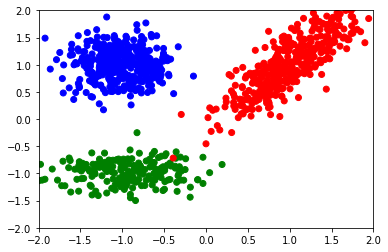

In [31]:
# sample from the learned distribution
pred_prior = np.random.choice(g.prior.shape[0], 1000, p=g.prior.softmax(0).detach().numpy())

x_means = g.mean.squeeze(0).detach().numpy()
x_cov = np.empty((g.prior.shape[0], 2, 2))
for i in range(g.prior.shape[0]):
    std1 = g.log_std[0, i, 0].exp().item()
    std2 = g.log_std[0, i, 1].exp().item()
    p = g.reparameterized_coef[0, i].tanh().item()

    x_cov[i, 0, 0] = std1 * std1
    x_cov[i, 1, 1] = std2 * std2
    x_cov[i, 0, 1] = std1 * std2 * p
    x_cov[i, 1, 0] = std1 * std2 * p

# then we sample the coordinates
pred = np.empty((1000, 2))
for i in range(1000):
    pred[i] = np.random.multivariate_normal(x_means[pred_prior[i]], x_cov[pred_prior[i]])

colors = np.array([c for c in "bgrcmyk"])
# you can do this if you want to visualize with more clusters,
# but several clusters will have the same color...
#colors = np.array([c for c in "bgrcmykbgrcmykbgrcmykbgrcmyk"])

fig, ax = plt.subplots()

ax.set_xlim((-2, 2))
ax.set_ylim((-2, 2))

ax.scatter(pred[:,0], pred[:,1], color=colors[pred_prior])